# Sie Siong Wong: Homework 3 - Chapter 6


### Code from the previous chapter



In [44]:
# Import packages
from modsim import *
from pandas import read_html

In [4]:
filename = 'World_population_estimates.html'
tables = read_html(filename, header=0, index_col=0, decimal='M')
table2 = tables[2]
table2.columns = ['census', 'prb', 'un', 'maddison', 
                  'hyde', 'tanton', 'biraben', 'mj', 
                  'thomlinson', 'durand', 'clark']

In [5]:
un = table2.un / 1e9
un.head()

Year
1950    2.525149
1951    2.572851
1952    2.619292
1953    2.665865
1954    2.713172
Name: un, dtype: float64

In [8]:
census = table2.census / 1e9
census.head()

Year
1950    2.557629
1951    2.594940
1952    2.636772
1953    2.682053
1954    2.730228
Name: census, dtype: float64

In [9]:
t_0 = get_first_label(census)
t_end = get_last_label(census)
elapsed_time = t_end - t_0

p_0 = get_first_value(census)
p_end = get_last_value(census)
total_growth = p_end - p_0

annual_growth = total_growth / elapsed_time

### System objects

We can rewrite the code from the previous chapter using system objects.

In [12]:
system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                annual_growth=annual_growth)

And we can encapsulate the code that runs the model in a function.

In [14]:
def run_simulation1(system):
    """Runs the constant growth model.
    
    system: System object
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = results[t] + system.annual_growth
    
    return results

We can also encapsulate the code that plots the results.

In [15]:
def plot_results(census, un, timeseries, title):
    """Plot the estimates and the model.
    
    census: TimeSeries of population estimates
    un: TimeSeries of population estimates
    timeseries: TimeSeries of simulation results
    title: string
    """
    plot(census, ':', label='US Census')
    plot(un, '--', label='UN DESA')
    plot(timeseries, color='gray', label='model')
    
    decorate(xlabel='Year', 
             ylabel='World population (billion)',
             title=title)

Here's how we run it.

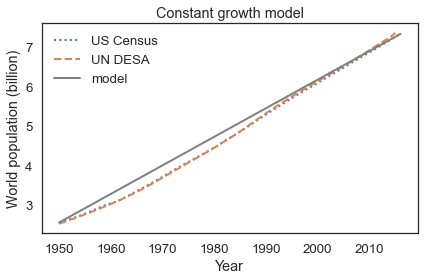

In [16]:
results = run_simulation1(system)
plot_results(census, un, results, 'Constant growth model')

## Proportional growth

Here's a more realistic model where the number of births and deaths is proportional to the current population.

In [18]:
def run_simulation2(system):
    """Run a model with proportional birth and death.
    
    system: System object
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        births = system.birth_rate * results[t]
        deaths = system.death_rate * results[t]
        results[t+1] = results[t] + births - deaths
        
    return results

I picked a death rate that seemed reasonable and then adjusted the birth rate to fit the data.

In [19]:
system.death_rate = 0.01
system.birth_rate = 0.027

Here's what it looks like.

Saving figure to file chap06-hw3-fig01.pdf


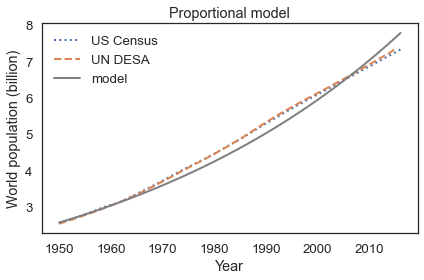

In [21]:
results = run_simulation2(system)
plot_results(census, un, results, 'Proportional model')
savefig('chap06-hw3-fig01.pdf')

The model fits the data pretty well for the first 20 years, but not so well after that.

### Factoring out the update function

`run_simulation1` and `run_simulation2` are nearly identical except the body of the loop.  So we can factor that part out into a function.

In [23]:
def update_func1(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    births = system.birth_rate * pop
    deaths = system.death_rate * pop
    return pop + births - deaths

The name `update_func` refers to a function object.

In [24]:
update_func1

<function __main__.update_func1(pop, t, system)>

Which we can confirm by checking its type.

In [25]:
type(update_func1)

function

`run_simulation` takes the update function as a parameter and calls it just like any other function.

In [27]:
def run_simulation(system, update_func):
    """Simulate the system using any update function.
    
    system: System object
    update_func: function that computes the population next year
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = update_func(results[t], t, system)
        
    return results

Here's how we use it.

In [28]:
t_0 = get_first_label(census)
t_end = get_last_label(census)
p_0 = census[t_0]

system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                birth_rate=0.027,
                death_rate=0.01)

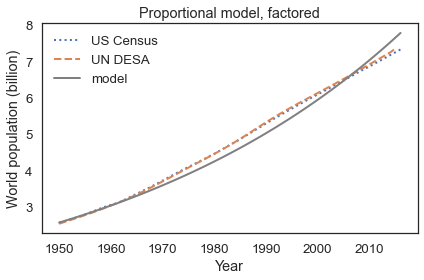

In [29]:
results = run_simulation(system, update_func1)
plot_results(census, un, results, 'Proportional model, factored')

Remember not to put parentheses after `update_func1`.  What happens if you try?

**Exercise:** When you run `run_simulation`, it runs `update_func1` once for each year between `t_0` and `t_end`.  To see that for yourself, add a print statement at the beginning of `update_func1` that prints the values of `t` and `pop`, then run `run_simulation` again.

In [45]:
# Include a print statement in the update_func1 function

def update_func1(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    print(f"Population: {pop}, Year: {t}.")
    births = system.birth_rate * pop
    deaths = system.death_rate * pop
    return pop + births - deaths


In [46]:
# Run the simulation
run_simulation(system, update_func1)

Population: 2.557628654, Year: 1950.
Population: 2.601108341118, Year: 1951.
Population: 2.645327182917006, Year: 1952.
Population: 2.6902977450265952, Year: 1953.
Population: 2.7360328066920476, Year: 1954.
Population: 2.7825453644058125, Year: 1955.
Population: 2.829848635600711, Year: 1956.
Population: 2.8779560624059233, Year: 1957.
Population: 2.926881315466824, Year: 1958.
Population: 2.9766382978297603, Year: 1959.
Population: 3.0272411488928666, Year: 1960.
Population: 3.078704248424045, Year: 1961.
Population: 3.131042220647254, Year: 1962.
Population: 3.184269938398258, Year: 1963.
Population: 3.2384025273510284, Year: 1964.
Population: 3.293455370315996, Year: 1965.
Population: 3.349444111611368, Year: 1966.
Population: 3.406384661508761, Year: 1967.
Population: 3.46429320075441, Year: 1968.
Population: 3.523186185167235, Year: 1969.
Population: 3.583080350315078, Year: 1970.
Population: 3.6439927162704344, Year: 1971.
Population: 3.7059405924470314, Year: 1972.
Population: 

,values
1950,2.557629
1951,2.601108
1952,2.645327
1953,2.690298
1954,2.736033
...,...
2012,7.273385
2013,7.397032
2014,7.522782
2015,7.650669


### Combining birth and death

Since births and deaths get added up, we don't have to compute them separately.  We can combine the birth and death rates into a single net growth rate.

In [47]:
def update_func2(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    net_growth = system.alpha  * pop
    return pop + net_growth

Here's how it works:

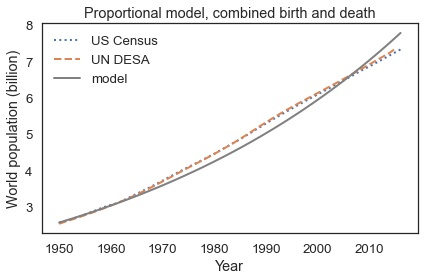

In [51]:
system.alpha = system.birth_rate - system.death_rate

results = run_simulation(system, update_func2)
plot_results(census, un, results, 'Proportional model, combined birth and death')

### Exercises

**Exercise:** Maybe the reason the proportional model doesn't work very well is that the growth rate, `alpha`, is changing over time.  So let's try a model with different growth rates before and after 1980 (as an arbitrary choice).

Write an update function that takes `pop`, `t`, and `system` as parameters.  The system object, `system`, should contain two parameters: the growth rate before 1980, `alpha1`, and the growth rate after 1980, `alpha2`.  It should use `t` to determine which growth rate to use.  Note: Don't forget the `return` statement.

Test your function by calling it directly, then pass it to `run_simulation`.  Plot the results.  Adjust the parameters `alpha1` and `alpha2` to fit the data as well as you can.



In [54]:
# Solution goes here

def update_func3(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    if t < 1980:
        net_growth = system.alpha1  * pop
    elif t >=  1980:
        net_growth = system.alpha2  * pop
        
    return pop + net_growth

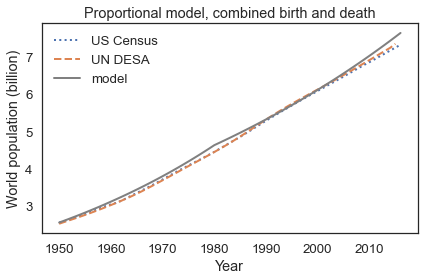

In [59]:
# Run the simulation

system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                alpha1=0.020,
                alpha2=0.014)

results = run_simulation(system, update_func3)
plot_results(census, un, results, 'Proportional model, combined birth and death')